# Meningioma (Brain Tumor) MRI Identification

This convolutional neural network distinguishes between MRI scans of healthy brains and brains with meningiomas with roughly 99% accuracy.

## Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, preprocessing, optimizers

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## File Processing

All the images are loaded and resized to a 64x64 resolution.

In [2]:
main_dir = "../input/brain-tumor-classification-mri/"
classification_dirs = [("no_tumor",), ("meningioma_tumor",)]
resolution = 64

def load_images(root_dir_name):
    x = []
    y = []
    
    for label, sub_dir_names in enumerate(classification_dirs):
        for sub_dir_name in sub_dir_names:
            print(f"loading {root_dir_name} {sub_dir_name}")
            sub_dir_path = os.path.join(main_dir, root_dir_name, sub_dir_name)
            for image_name in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, image_name)
                image = preprocessing.image.load_img(image_path, color_mode="grayscale", target_size=(resolution, resolution))
                x.append(preprocessing.image.img_to_array(image))
                y.append(label)
    
    x = np.array(x) / 255.0
    y = np.array(y)
    
    return x, y

x_train, y_train = load_images("Training")
x_test, y_test = load_images("Testing")

print("done loading!")
print("\nshapes:")
print(x_train.shape)
print(x_test.shape)

loading Training no_tumor
loading Training meningioma_tumor
loading Testing no_tumor
loading Testing meningioma_tumor
done loading!

shapes:
(1217, 64, 64, 1)
(220, 64, 64, 1)


## Data Visualization

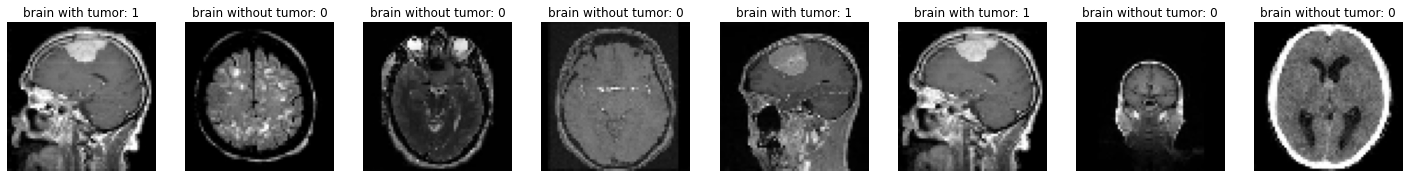

In [3]:
c = 8

fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(x_test))
    num = y_test[n]
    word = "out" if num == 0 else ""
    
    subplots[i].imshow(x_test[n].reshape((resolution, resolution)), cmap="gray")
    subplots[i].set_title(f"brain with{word} tumor: {num}")
    subplots[i].axis("off")
plt.show()

## Model Definition

In [4]:
model = keras.Sequential([
    layers.Input((resolution, resolution, 1)),
    layers.Conv2D(32, (3, 3), activation="linear", padding="same"),
    layers.MaxPooling2D(2, 2), # 32 x 32
    layers.Conv2D(64, (3, 3), activation="linear", padding="same"),
    layers.MaxPooling2D(2, 2), # 16 x 16
    layers.Conv2D(128, (3, 3), activation="linear", padding="same"),
    layers.MaxPooling2D(2, 2), # 8 x 8
    layers.Conv2D(32, (3, 3), activation="linear", padding="same"),
    layers.MaxPooling2D(2, 2), # 4 x 4
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="linear"), # 128 and 256 got 94% after 15 epochs
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          3

## Model Fitting

In [5]:
history = model.fit(x_train, y_train, batch_size=4, shuffle=True, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
305/305 [==============================] - 2s 6ms/step - loss: 0.5448 - accuracy: 0.7494 - val_loss: 0.9899 - val_accuracy: 0.5364
Epoch 2/15
305/305 [==============================] - 1s 4ms/step - loss: 0.3623 - accuracy: 0.8480 - val_loss: 0.3801 - val_accuracy: 0.8682
Epoch 3/15
305/305 [==============================] - 1s 4ms/step - loss: 0.2773 - accuracy: 0.8915 - val_loss: 0.3853 - val_accuracy: 0.8955
Epoch 4/15
305/305 [==============================] - 1s 4ms/step - loss: 0.1946 - accuracy: 0.9244 - val_loss: 0.1562 - val_accuracy: 0.9636
Epoch 5/15
305/305 [==============================] - 1s 4ms/step - loss: 0.1352 - accuracy: 0.9491 - val_loss: 0.2926 - val_accuracy: 0.8909
Epoch 6/15
305/305 [==============================] - 1s 4ms/step - loss: 0.1123 - accuracy: 0.9581 - val_loss: 0.4733 - val_accuracy: 0.8273
Epoch 7/15
305/305 [==============================] - 1s 4ms/step - loss: 0.1030 - accuracy: 0.9655 - val_loss: 0.1397 - val_accuracy: 0.9591
Epoch 

## Model Testing

Let's see if it actually works on unseen data.

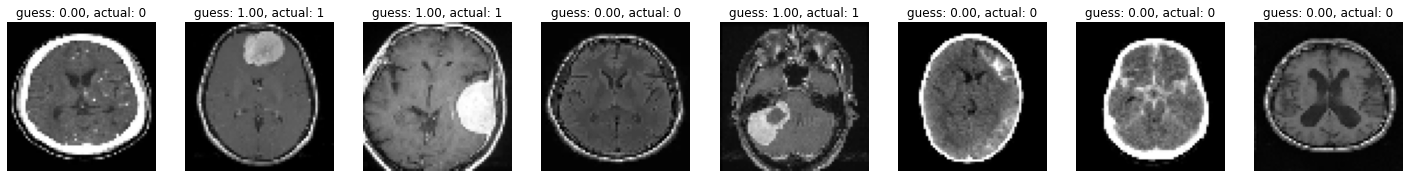

In [6]:
y_test_results = model.predict([x_test])

c = 8

fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(x_test))
    guess = str(round(y_test_results[n][0], 2)).ljust(4, "0")
    actual = y_test[n]

    subplot = subplots[i]
    subplot.imshow(x_test[n].reshape((resolution, resolution)), cmap="gray")
    subplot.set_title(f"guess: {guess}, actual: {actual}")
    subplot.axis("off")
plt.show()